In [520]:
import pandas as pd
from pandas import read_csv 
import numpy as np
import datetime
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import collections

In [521]:
dataset=read_csv('soc-sign-bitcoinotc.csv',header=None, names=["source", "target", "rating","time"])

In [522]:
print(dataset.head(5))
print(dataset.shape)

   source  target  rating          time
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09
(35592, 4)


In [523]:
# arrtime=[]
# for a in dataset.iloc[:,-1]:
#     arrtime.append(datetime.datetime.fromtimestamp(a))

In [524]:
# dataset.drop('time', inplace=True, axis=1)    
# dataset.insert(3, "time", arrtime, True)
# print(dataset.head(5))

In [525]:
dataset.loc[pd.DataFrame(np.sort(dataset[['source','target']],1),index=dataset.index).drop_duplicates(keep='first').index]
dataset.head(5)

,source,target,rating,time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [526]:
dataset['time'] = pd.to_datetime(dataset.time * 1e9)
dataset = dataset.set_index('time')
dataset.shape

(35592, 3)

In [527]:
dataset.tail(5)

,source,target,rating
time,,,
2016-01-24 05:14:41.647290112,4499,1810,1
2016-01-24 23:50:28.049489920,2731,3901,5
2016-01-24 23:50:34.034019840,2731,4897,5
2016-01-24 23:53:52.985709824,13,1128,1
2016-01-25 01:12:03.757280000,1128,13,2


In [528]:
# ratings overview by month
dataset.resample('M').rating.value_counts().unstack().sample(5)

rating,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
time,,,,,,,,,,,,,,,,,,,,
2012-09-30,190.0,NaN,NaN,2.0,NaN,9.0,6.0,12.0,3.0,22.0,511.0,133.0,73.0,25.0,49.0,9.0,10.0,21.0,16.0,62.0
2015-05-31,4.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,98.0,17.0,18.0,5.0,7.0,2.0,2.0,NaN,NaN,2.0
2011-10-31,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.0,47.0,17.0,6.0,9.0,1.0,NaN,NaN,1.0,2.0
2011-11-30,3.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,192.0,57.0,22.0,4.0,10.0,1.0,NaN,3.0,1.0,1.0
2013-04-30,66.0,2.0,3.0,NaN,NaN,3.0,NaN,3.0,5.0,26.0,1106.0,277.0,138.0,40.0,67.0,7.0,5.0,8.0,6.0,55.0


In [529]:
tp1 = dataset.loc['2013']
print(f"Ratings: {len(tp1)}")
tp1.sample(10)

Ratings: 12982


,source,target,rating
time,,,
2013-04-07 22:41:04.542590208,3735,606,1
2013-02-14 06:22:06.258579968,13,3483,1
2013-07-02 02:20:05.819830272,3699,2600,1
2013-04-04 21:22:09.142710016,3863,3776,5
2013-08-19 06:21:04.629040128,4568,2942,1
2013-08-23 00:53:54.975739904,1810,3278,6
2013-08-21 02:44:58.666230016,4320,2600,1
2013-07-19 20:42:58.613289984,4581,4571,1
2013-11-15 07:40:24.423359744,4988,5016,5


In [530]:
G = nx.Graph()
for i in tp1.index:
  G.add_edge(dataset['source'][i], dataset['target'][i], weight = dataset['rating'][i])

In [531]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 2682\nNumber of edges: 8224\nAverage degree:   6.1327'

In [532]:
# nx.draw(G)  
# plt.draw()
nx.is_connected(G)

False

target
1       22
2        2
3        3
4        5
6        8
        ..
5254     1
5255     2
5256     1
5257     1
5258     1
Name: rating, Length: 2635, dtype: int64
target
1       2.909091
2       3.000000
3      -7.000000
4       3.600000
6       1.875000
          ...   
5254    1.000000
5255    1.000000
5256    1.000000
5257    1.000000
5258    1.000000
Name: rating, Length: 2635, dtype: float64


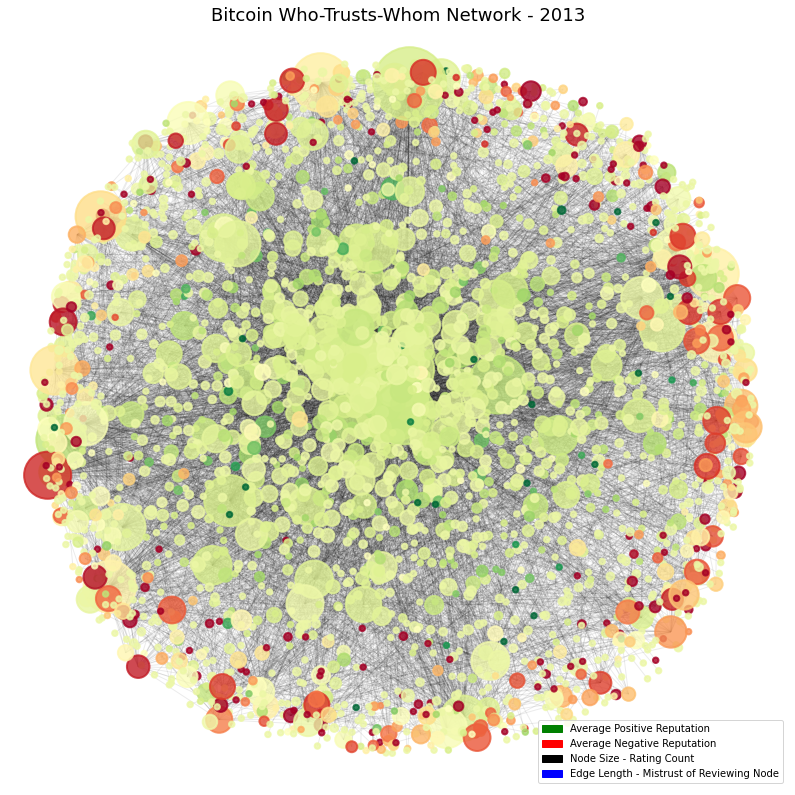

In [533]:
review_counts = tp1.groupby('target').rating.count()
average_reviews = tp1.groupby('target').rating.mean()
print(review_counts)
print(average_reviews)
def get_size(user_id, m=20, min=30):
    s = review_counts.get(user_id)
    if s is not None:
        return min * s
    else:
        return min

def get_color(user_id):
    s = average_reviews.get(user_id)
    if s is None:
        return 0.5
    # need a scaling function to translate -10-10 to 0.0-1.0 for colors maps
    return np.interp(s, (-10, 10), (0, 1))

plt.figure(figsize=(14, 14)) 
plt.title("Bitcoin Who-Trusts-Whom Network - 2013", fontsize=18)

untrusted = mpatches.Patch(color='red', label='Average Negative Reputation')
trusted = mpatches.Patch(color='green', label='Average Positive Reputation')
size = mpatches.Patch(color='black', label='Node Size - Rating Count')
edges = mpatches.Patch(color='blue', label='Edge Length - Mistrust of Reviewing Node')
plt.legend(handles=[trusted, untrusted, size, edges], loc='lower right')

pos = nx.spring_layout(G, k=0.25)
sizes = [get_size(n) for n in G]
colors = [get_color(n) for n in G]

nc = nx.draw_networkx_nodes(
    G, pos, nodelist=G.nodes(), node_size=sizes, linewidths=2.0,
    node_color=colors, cmap=plt.cm.RdYlGn, alpha=0.8
)
ec = nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.08)
ax = plt.axis('off')
plt.show()

[Text(0, 0, '348'),
 Text(0, 0, '283'),
 Text(0, 0, '236'),
 Text(0, 0, '223'),
 Text(0, 0, '207'),
 Text(0, 0, '176'),
 Text(0, 0, '143'),
 Text(0, 0, '136'),
 Text(0, 0, '134'),
 Text(0, 0, '131'),
 Text(0, 0, '119'),
 Text(0, 0, '116'),
 Text(0, 0, '105'),
 Text(0, 0, '104'),
 Text(0, 0, '103'),
 Text(0, 0, '99'),
 Text(0, 0, '95'),
 Text(0, 0, '90'),
 Text(0, 0, '88'),
 Text(0, 0, '86'),
 Text(0, 0, '84'),
 Text(0, 0, '74'),
 Text(0, 0, '73'),
 Text(0, 0, '71'),
 Text(0, 0, '70'),
 Text(0, 0, '69'),
 Text(0, 0, '68'),
 Text(0, 0, '67'),
 Text(0, 0, '63'),
 Text(0, 0, '62'),
 Text(0, 0, '57'),
 Text(0, 0, '55'),
 Text(0, 0, '54'),
 Text(0, 0, '53'),
 Text(0, 0, '52'),
 Text(0, 0, '49'),
 Text(0, 0, '48'),
 Text(0, 0, '47'),
 Text(0, 0, '46'),
 Text(0, 0, '45'),
 Text(0, 0, '44'),
 Text(0, 0, '43'),
 Text(0, 0, '42'),
 Text(0, 0, '40'),
 Text(0, 0, '39'),
 Text(0, 0, '38'),
 Text(0, 0, '37'),
 Text(0, 0, '36'),
 Text(0, 0, '35'),
 Text(0, 0, '34'),
 Text(0, 0, '33'),
 Text(0, 0, '32'

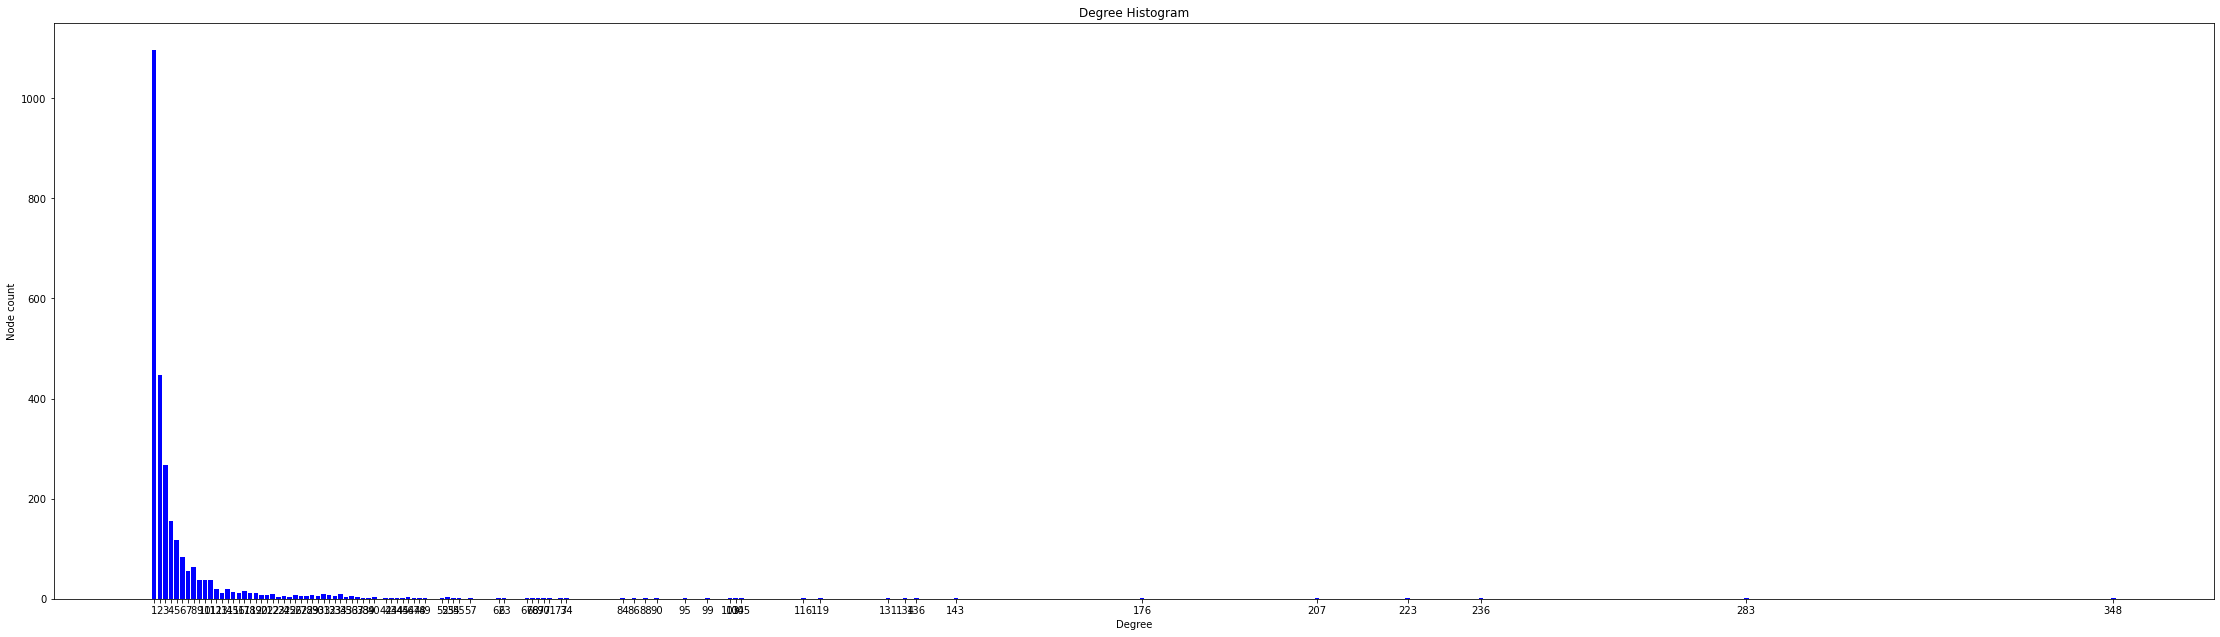

In [534]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
#plt.figure(figsize = (200, 100))
plt.subplots_adjust(left=0, right=5, bottom=0, top=2)
plt.bar(deg, cnt, width=0.8, color="b")
plt.title("Degree Histogram")
plt.ylabel("Node count")
plt.xlabel("Degree")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)

In [ ]:
l = []
for i in dataset.index:
    if(dataset['rating'][i]<0):
        l.append(dataset['source'][i])
#print(l)  

x = nx.closeness_centrality(G)
import operator
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_x[-20:]:
    closeness.append(i[0])
#print(closeness)    
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("closeness - fraudulent nodes :" , np.unique(common))      

y = nx.degree_centrality(G)
import operator
sorted_y = sorted(y.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_y[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("degree - fraudulent nodes :" , np.unique(common)) 

z = nx.betweenness_centrality(G)
import operator
sorted_z = sorted(z.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_z[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("betweeness - fraudulent nodes :" , np.unique(common)) 

a = nx.pagerank(G,max_iter=10000)
import operator
sorted_a = sorted(a.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_a[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("pagerank - fraudulent nodes :" , np.unique(common)) 


closeness - fraudulent nodes : [  35  905 1018 1334 1810 2125 2296 2388 2642 3465 3649 3828 3916 4172
 4197 4291]
degree - fraudulent nodes : [  35  905 1018 1334 1810 2028 2125 2296 2388 2642 2942 3649 3744 3897
 4172 4197 4291]
betweeness - fraudulent nodes : [  35  905 1018 1334 1810 1953 2028 2125 2266 2296 2388 2642 2897 3018
 3744 4172 4197]


c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:154: RuntimeWarning: overflow encountered in double_scalars
  err = sum([abs(x[n] - xlast[n]) for n in x])
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:151: RuntimeWarning: overflow encountered in double_scalars
  x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:151: RuntimeWarning: invalid value encountered in double_scalars
  x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:146: RuntimeWarning: invalid value encountered in double_scalars
  danglesum = alpha * sum(xlast[n] for n in dangling_nodes)


In [ ]:
# y = nx.degree_centrality(G)
# import operator
# sorted_y = sorted(y.items(), key=operator.itemgetter(1))
# print(sorted_y[-20:])

In [ ]:
# z = nx.betweenness_centrality(G)
# import operator
# sorted_z = sorted(z.items(), key=operator.itemgetter(1))
# print(sorted_z[-20:])

In [ ]:
# a = nx.pagerank(G,max_iter=10000)
# import operator
# sorted_a = sorted(a.items(), key=operator.itemgetter(1))
# print(sorted_a[-20:])

In [ ]:
# l = []
# for i in dataset.index:
#     if(dataset['rating'][i]<0):
#         l.append(dataset['source'][i])
# print(l)        


In [ ]:
# common=[]
# for i in sorted_x[-20:]:
#     for j in l:
#         if i==j:
#             common.append(j)
# print(common)            